In [1]:
# ================================================
# SECTION 1: Mount Google Drive & Set Base Path
# ================================================
from google.colab import drive
import os

# ================================================
# Set Random Seeds for Reproducibility
# ================================================
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Mount Google Drive
drive.mount('/content/drive')

# Set the base dataset path
DATASET_ROOT = '/content/drive/MyDrive/ChestXray14'

# Check existence
assert os.path.exists(DATASET_ROOT), "Dataset folder not found."
print("Drive mounted. Dataset folder ready.")


Mounted at /content/drive
Drive mounted. Dataset folder ready.


In [2]:
# =====================================================
# 📄 SECTION 2: Load CSV and Filter for Target Diseases
# =====================================================
import pandas as pd

# Path to the CSV file
CSV_PATH = os.path.join(DATASET_ROOT, "Data_Entry_2017_v2020.csv")

# Load the dataset
df = pd.read_csv(CSV_PATH)

# Normalize column names just in case
df.columns = [col.strip() for col in df.columns]

# Target diseases for this research
target_diseases = ['Hernia', 'Fibrosis']

# Filter rows that contain at least one of the target diseases
df_filtered = df[df['Finding Labels'].str.contains('Hernia|Fibrosis', na=False)].copy()

# Preview result
print(f"Filtered to {len(df_filtered)} entries with Hernia or Fibrosis.")
df_filtered[['Image Index', 'Finding Labels']].head()


Filtered to 1905 entries with Hernia or Fibrosis.


,Image Index,Finding Labels
4,00000003_001.png,Hernia
5,00000003_002.png,Hernia
6,00000003_003.png,Hernia|Infiltration
7,00000003_004.png,Hernia
8,00000003_005.png,Hernia


In [3]:
# =====================================================================
# SECTION 3: Match Each Image Index with Its Folder (001 or 002)
# =====================================================================
image_folders = ["images_001", "images_002", "images_003", "images_004", "images_005","images_006","images_007","images_008","images_009","images_010","images_011","images_012"]

# Rebuild the lookup dictionary
image_lookup = {}

for folder in image_folders:
    folder_path = os.path.join(DATASET_ROOT, folder)
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(".png"):
                image_lookup[filename.strip().lower()] = folder

# Normalize image names in CSV for consistent matching
df_filtered["Image Index"] = df_filtered["Image Index"].str.strip().str.lower()

# Map filenames to folder
df_filtered["Folder"] = df_filtered["Image Index"].map(image_lookup)

# Drop unmatched entries
df_filtered = df_filtered.dropna(subset=["Folder"])

# Confirm matches
print(f"Remaining after image match: {len(df_filtered)}")
df_filtered[['Image Index', 'Folder', 'Finding Labels']].head()


Remaining after image match: 1905


,Image Index,Folder,Finding Labels
4,00000003_001.png,images_001,Hernia
5,00000003_002.png,images_001,Hernia
6,00000003_003.png,images_001,Hernia|Infiltration
7,00000003_004.png,images_001,Hernia
8,00000003_005.png,images_001,Hernia


In [4]:
# =======================================================
# 🧪 SECTION 4: Image Preprocessing & Augmentation Setup
# =======================================================
import torchvision.transforms as transforms
from PIL import Image

# Define the common image size used for models like ResNet/DenseNet
IMAGE_SIZE = 224

# Image preprocessing and augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),   # Resize to uniform size
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize([0.485], [0.229])          # Normalize (mean, std) for grayscale
])

# Custom function to load image given folder and filename
def load_image(folder, filename):
    image_path = os.path.join(DATASET_ROOT, folder, filename)

    try:
        image = Image.open(image_path).convert('L')  # Load as grayscale
        return transform(image)
    except Exception as e:
        print(f"Error loading image: {filename} - {e}")
        return None

# Example: Preview transformed image tensor
sample_row = df_filtered.iloc[0]
sample_tensor = load_image(sample_row['Folder'], sample_row['Image Index'])

# Check dimensions of one image after preprocessing
if sample_tensor is not None:
    print("Image tensor shape:", sample_tensor.shape)

Image tensor shape: torch.Size([1, 224, 224])


Image tensor shape: torch.Size([1, 224, 224])


/tmp/ipython-input-5-332752242.py:58: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


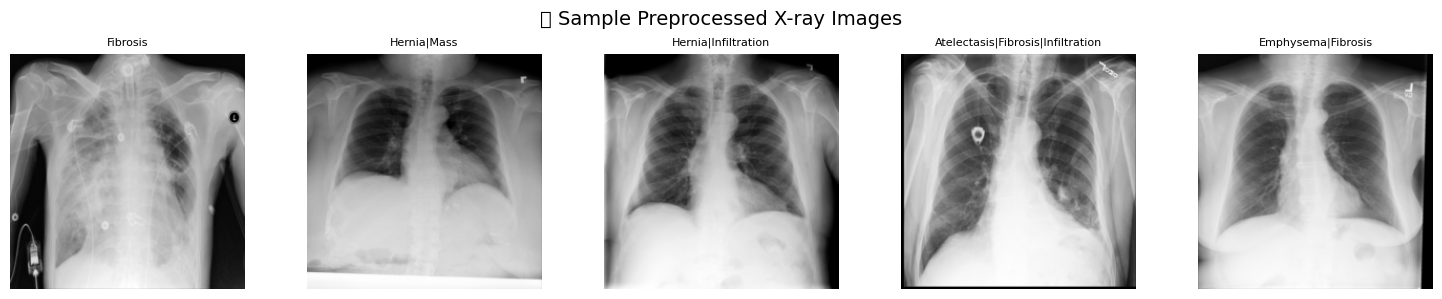

/tmp/ipython-input-5-332752242.py:70: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


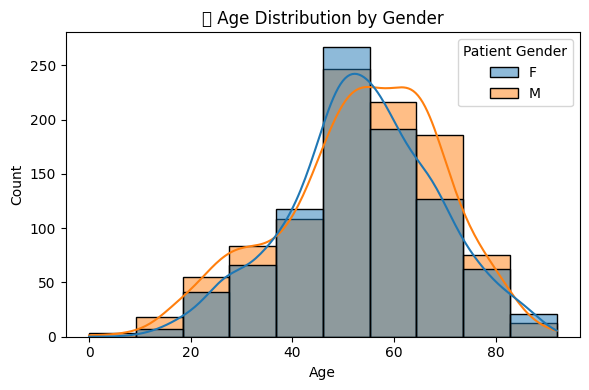

Missing Metadata Summary:
Finding Labels    0
Patient Age       0
Patient Gender    0
dtype: int64


In [5]:
# ==================================================
# SECTION 4B: Preview Sample Images from Dataset
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from PIL import Image

# Define the common image size used for models like ResNet/DenseNet
IMAGE_SIZE = 224

# Image preprocessing and augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),   # Resize to uniform size
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize([0.485], [0.229])          # Normalize (mean, std) for grayscale
])

# Custom function to load image given folder and filename
def load_image(folder, filename):
    image_path = os.path.join(DATASET_ROOT, folder, filename)

    try:
        image = Image.open(image_path).convert('L')  # Load as grayscale
        return transform(image)
    except Exception as e:
        print(f"Error loading image: {filename} - {e}")
        return None

# Example: Preview transformed image tensor
sample_row = df_filtered.iloc[0]
sample_tensor = load_image(sample_row['Folder'], sample_row['Image Index'])

# Check dimensions of one image after preprocessing
if sample_tensor is not None:
    print("Image tensor shape:", sample_tensor.shape)


# Preview N images
N = 5
sample_rows = df_filtered.sample(N, random_state=42)

plt.figure(figsize=(15, 3))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_tensor = load_image(row["Folder"], row["Image Index"])
    label_text = row["Finding Labels"]

    if img_tensor is not None:
        # Convert tensor to numpy image
        img_np = img_tensor.squeeze().numpy()  # [1, H, W] → [H, W]

        plt.subplot(1, N, i+1)
        plt.imshow(img_np, cmap="gray")
        plt.title(label_text, fontsize=8)
        plt.axis('off')

plt.suptitle("🔍 Sample Preprocessed X-ray Images", fontsize=14)
plt.tight_layout()
plt.show()


# ================================================
# Age & Gender Distribution
# ================================================
plt.figure(figsize=(6, 4))
sns.histplot(data=df_filtered, x="Patient Age", hue="Patient Gender", bins=10, kde=True)
plt.title("👥 Age Distribution by Gender")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# ================================================
# Missing Metadata Summary
# ================================================
missing_summary = df_filtered[["Finding Labels", "Patient Age", "Patient Gender"]].isnull().sum()
print("Missing Metadata Summary:")
print(missing_summary)

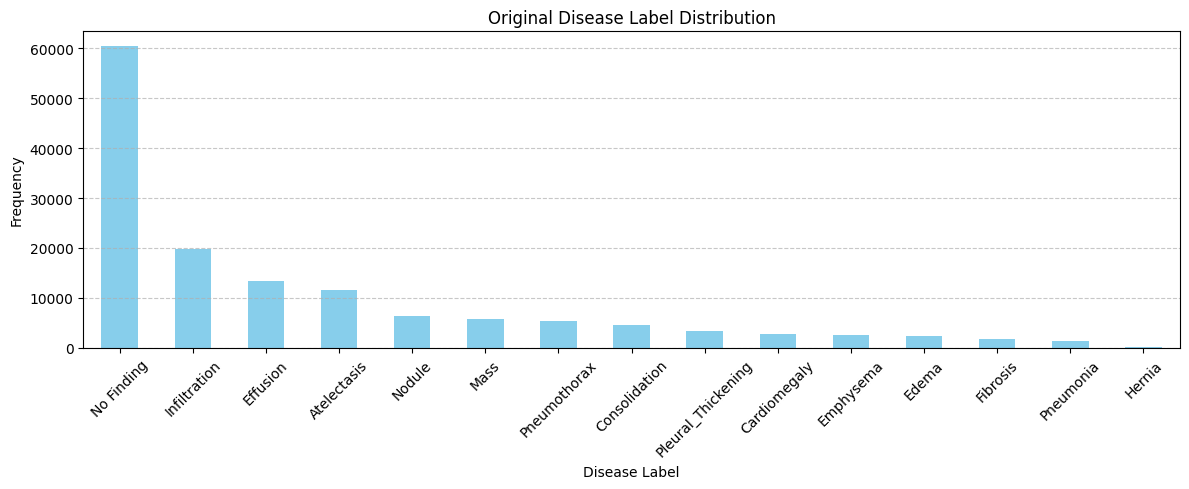

/tmp/ipython-input-6-2901629657.py:38: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


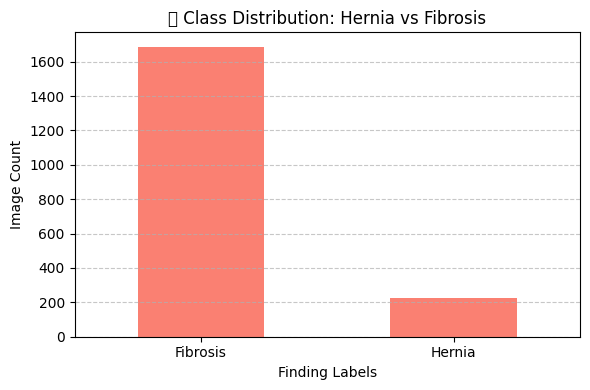

In [6]:
# ================================================
# SECTION 2B: Visualize Original Disease Distribution
# ================================================
from collections import Counter
from itertools import chain

# Split multilabel entries and count all labels
all_labels = list(chain.from_iterable(df["Finding Labels"].dropna().str.split('|')))
label_counts = pd.Series(Counter(all_labels)).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Original Disease Label Distribution")
plt.xlabel("Disease Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# ================================================
# SECTION 3B: Visualize Class Counts After Filtering
# ================================================
filtered_labels = df_filtered["Finding Labels"].str.split('|').explode()
target_label_counts = filtered_labels[filtered_labels.isin(target_diseases)].value_counts()

# Plot
plt.figure(figsize=(6, 4))
target_label_counts.plot(kind='bar', color='salmon')
plt.title("🩻 Class Distribution: Hernia vs Fibrosis")
plt.ylabel("Image Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
# Add 'Primary Label' column for stratification
df_filtered['Primary Label'] = df_filtered['Finding Labels'].apply(
    lambda x: 'Hernia' if 'Hernia' in x else ('Fibrosis' if 'Fibrosis' in x else 'Both')
)

# Remove the 'Both' class (only 1 sample, not suitable for stratified split)
df_filtered = df_filtered[df_filtered['Primary Label'] != 'Both'].copy()

# ============================================
# 🧪 SECTION 5: Dataset Splitting (Fixed)
# ============================================
from sklearn.model_selection import train_test_split

# Use the simplified column for stratification
label_col = "Primary Label"

# Step 1: Train (70%) and Temp (30%) split
train_df, temp_df = train_test_split(
    df_filtered,
    test_size=0.30,
    stratify=df_filtered[label_col],
    random_state=42
)

# Step 2: Split Temp into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[label_col],
    random_state=42
)

# Step 3: Print split counts
print(f"Train Set: {len(train_df)}")
print(f"Validation Set: {len(val_df)}")
print(f"Test Set: {len(test_df)}")

# Step 4: Save the splits
split_dir = os.path.join(DATASET_ROOT, "splits")
os.makedirs(split_dir, exist_ok=True)

train_df.to_csv(os.path.join(split_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(split_dir, "val.csv"), index=False)
test_df.to_csv(os.path.join(split_dir, "test.csv"), index=False)

print("Splits saved to: ChestXray14/splits/")

Train Set: 1333
Validation Set: 286
Test Set: 286
Splits saved to: ChestXray14/splits/


In [8]:
df_filtered["Primary Label"].value_counts()


,count
Primary Label,
Fibrosis,1678
Hernia,227


In [9]:
# ==========================================================
# 🔧 SECTION 6: PyTorch Dataset Class & Dataloader Setup
# ==========================================================
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

# Paths
DATASET_ROOT = "/content/drive/MyDrive/ChestXray14"
split_dir = os.path.join(DATASET_ROOT, "splits")

# ImageNet normalization (used by pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Reload split data
train_df = pd.read_csv(os.path.join(split_dir, "train.csv"))
val_df = pd.read_csv(os.path.join(split_dir, "val.csv"))
test_df = pd.read_csv(os.path.join(split_dir, "test.csv"))

# Custom Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, task='mtl'):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.task = task

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['Image Index']
        finding_labels = row['Finding Labels'] # Use the original finding labels
        img_path = os.path.join(self.root_dir, row['Folder'], img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_name} - {e}")
            image = Image.new("RGB", (224, 224))

        if self.transform:
            image = self.transform(image)

        if self.task == 'mtl':
            # Encode labels for MTL: Create a tensor indicating presence of Hernia and Fibrosis
            label_tensor = torch.tensor([
                1.0 if 'Hernia' in finding_labels else 0.0,
                1.0 if 'Fibrosis' in finding_labels else 0.0
            ], dtype=torch.float) # Use float for BCEWithLogitsLoss or BCELoss with sigmoid output
        elif self.task == 'hernia':
            label_tensor = torch.tensor([1.0 if 'Hernia' in finding_labels else 0.0], dtype=torch.float)
        elif self.task == 'fibrosis':
            label_tensor = torch.tensor([1.0 if 'Fibrosis' in finding_labels else 0.0], dtype=torch.float)
        else:
            raise ValueError("Invalid task specified for ChestXrayDataset")

        return image, label_tensor

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Dataset objects
train_dataset = ChestXrayDataset(train_df, DATASET_ROOT, transform=train_transform, task='mtl')
val_dataset = ChestXrayDataset(val_df, DATASET_ROOT, transform=eval_transform, task='mtl')
test_dataset = ChestXrayDataset(test_df, DATASET_ROOT, transform=eval_transform, task='mtl')


# DataLoaders (adjust batch_size as needed)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


# Preview a batch shape
sample_batch = next(iter(train_loader))
print("Image batch shape:", sample_batch[0].shape)
print("Label batch shape:", sample_batch[1].shape)

Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16, 2])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


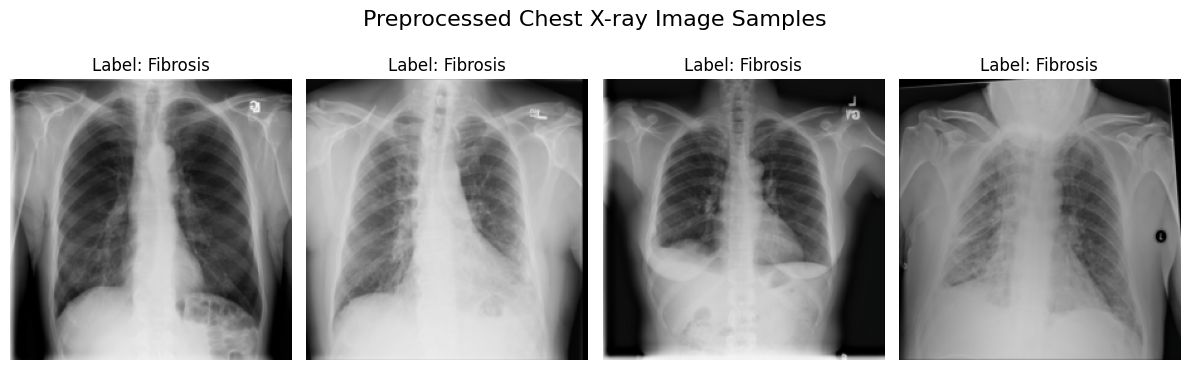

In [10]:
# ===============================
# 1. Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Reload Dataset + CSVs
# ===============================
import os
import pandas as pd

DATASET_ROOT = "/content/drive/MyDrive/ChestXray14"
split_dir = os.path.join(DATASET_ROOT, "splits")
train_df = pd.read_csv(os.path.join(split_dir, "train.csv"))

# ===============================
# 3. Define Dataset & Transforms
# ===============================
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, task='mtl'):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.task = task

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        folder = row['Folder']
        img_name = row['Image Index']
        finding_labels = row['Finding Labels']  # raw label string
        img_path = os.path.join(self.root_dir, folder, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_name} - {e}")
            image = Image.new("RGB", (224, 224))

        if self.transform:
            image = self.transform(image)

        if self.task == 'mtl':
            label_tensor = torch.tensor([
                1.0 if 'Hernia' in finding_labels else 0.0,
                1.0 if 'Fibrosis' in finding_labels else 0.0
            ], dtype=torch.float)
        elif self.task == 'hernia':
            label_tensor = torch.tensor([1.0 if 'Hernia' in finding_labels else 0.0], dtype=torch.float)
        elif self.task == 'fibrosis':
            label_tensor = torch.tensor([1.0 if 'Fibrosis' in finding_labels else 0.0], dtype=torch.float)
        else:
            raise ValueError("Invalid task specified: choose 'mtl', 'hernia', or 'fibrosis'")

        return image, label_tensor
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# ===============================
# 4. Rebuild Loader & Preview Images
# ===============================
train_dataset = ChestXrayDataset(train_df, DATASET_ROOT, transform=transform)
tiny_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
tiny_batch = next(iter(tiny_loader))

# Visualization
import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor, label_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # Decode label
    if isinstance(label_tensor, torch.Tensor):
        label_tensor = label_tensor.numpy()

    if len(label_tensor) == 2:
        label_str = []
        if label_tensor[0] == 1:
            label_str.append("Hernia")
        if label_tensor[1] == 1:
            label_str.append("Fibrosis")
        label_display = " & ".join(label_str) if label_str else "No Finding"
    else:
        label_display = "Hernia" if label_tensor[0] == 1 else "Fibrosis"

    plt.title(f"Label: {label_display}")
    plt.axis('off')

# Visualize
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(tiny_batch[0][i], tiny_batch[1][i])
plt.suptitle("Preprocessed Chest X-ray Image Samples", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# ================================================
# SECTION 7.1: Multi-Task Learning Model
# ================================================
import torch.nn as nn
import torchvision.models as models

# Shared ResNet18 Backbone
class MTL_ResNet18(nn.Module):
    def __init__(self):
        super(MTL_ResNet18, self).__init__()
        base_model = models.resnet18(weights="IMAGENET1K_V1")
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # [B, 512, 1, 1]
        self.head_hernia = nn.Linear(512, 1)
        self.head_fibrosis = nn.Linear(512, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        out_hernia = self.head_hernia(x)     # No sigmoid
        out_fibrosis = self.head_fibrosis(x) # No sigmoid
        return out_hernia, out_fibrosis

In [12]:
# Instantiate the model
mtl_model = MTL_ResNet18()

# Create a dummy input batch (e.g., 4 grayscale X-rays converted to RGB)
dummy_input = torch.randn(4, 3, 224, 224)

# Forward pass through the model
out_hernia, out_fibrosis = mtl_model(dummy_input)

print("Hernia Output:", out_hernia.shape)
print("Fibrosis Output:", out_fibrosis.shape)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


Hernia Output: torch.Size([4, 1])
Fibrosis Output: torch.Size([4, 1])


In [13]:
# =================================================
# SECTION 7.2: Ensemble Architecture Definition
# =================================================
import torchvision.models as models
import torch.nn as nn

# Individual ResNet-based binary classifier
class BinaryResNet18(nn.Module):
    def __init__(self):
        super(BinaryResNet18, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)  # Single output unit
        self.model = base_model

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# Create separate models for each disease
ensemble_hernia_model = BinaryResNet18()
ensemble_fibrosis_model = BinaryResNet18()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
dummy_input = torch.randn(4, 3, 224, 224)
out_h = ensemble_hernia_model(dummy_input)
out_f = ensemble_fibrosis_model(dummy_input)

print("Hernia prediction shape:", out_h.shape)
print("Fibrosis prediction shape:", out_f.shape)


Hernia prediction shape: torch.Size([4, 1])
Fibrosis prediction shape: torch.Size([4, 1])


In [15]:
# ===================================================
# SECTION 8: Training Utilities (MTL & Ensemble)
# ===================================================

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute positive class weights from train_df
hernia_weight = len(train_df) / (2 * len(train_df[train_df['Primary Label'] == 'Hernia']))
fibrosis_weight = len(train_df) / (2 * len(train_df[train_df['Primary Label'] == 'Fibrosis']))

# Convert to tensors
hernia_pos_weight = torch.tensor([hernia_weight], dtype=torch.float).to(device)
fibrosis_pos_weight = torch.tensor([fibrosis_weight], dtype=torch.float).to(device)
mtl_pos_weights = torch.tensor([hernia_weight, fibrosis_weight], dtype=torch.float).to(device)

# Define separate loss functions
bce_loss_hernia = nn.BCEWithLogitsLoss(pos_weight=hernia_pos_weight)
bce_loss_fibrosis = nn.BCEWithLogitsLoss(pos_weight=fibrosis_pos_weight)
bce_loss_mtl = nn.BCEWithLogitsLoss(pos_weight=mtl_pos_weights)

# Optimizers
mtl_optimizer = optim.Adam(mtl_model.parameters(), lr=1e-4)
ensemble_optimizer_h = optim.Adam(ensemble_hernia_model.parameters(), lr=1e-4)
ensemble_optimizer_f = optim.Adam(ensemble_fibrosis_model.parameters(), lr=1e-4)

# Move models to GPU
mtl_model.to(device)
ensemble_hernia_model.to(device)
ensemble_fibrosis_model.to(device)


BinaryResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [17]:
# ===================================================
# SECTION 9: Training & Validation Loops (MTL & Ensemble)
# ===================================================

from tqdm import tqdm

def train_one_epoch(model, optimizer, dataloader, is_mtl=False, task=None):
    model.train()
    total_loss = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        if is_mtl:
            out_h, out_f = outputs
            loss_h = bce_loss_hernia(out_h.squeeze(-1), labels[:, 0].float())
            loss_f = bce_loss_fibrosis(out_f.squeeze(-1), labels[:, 1].float())
            loss = loss_h + loss_f
        else:
            # Labels are already [batch_size, 1] from the dataset for non-MTL tasks
            if task == 'hernia':
                loss = bce_loss_hernia(outputs, labels)
            elif task == 'fibrosis':
                loss = bce_loss_fibrosis(outputs, labels)
            else:
                raise ValueError("Specify task for non-MTL training")


        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_model(model, dataloader, is_mtl=True, task=None):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if is_mtl:
                out_h, out_f = outputs
                loss_h = bce_loss_hernia(out_h.squeeze(-1), labels[:, 0].float())
                loss_f = bce_loss_fibrosis(out_f.squeeze(-1), labels[:, 1].float())
                loss = loss_h + loss_f

                preds = torch.cat((out_h, out_f), dim=1) > 0.5
                correct += (preds.int() == labels.int()).all(dim=1).sum().item()
                total += labels.size(0)
            else:
                # Labels are already [batch_size, 1] from the dataset for non-MTL tasks
                if task == 'hernia':
                    loss = bce_loss_hernia(outputs, labels)
                    preds = (outputs > 0.5).int()
                elif task == 'fibrosis':
                    loss = bce_loss_fibrosis(outputs, labels)
                    preds = (outputs > 0.5).int()
                else:
                    raise ValueError("Specify task for non-MTL validation")


                labels = labels.int() # Keep labels as [batch_size, 1] for accuracy calculation
                preds = preds.int() # Keep predictions as [batch_size, 1] for accuracy calculation

                correct += (preds == labels).sum().item()
                total += labels.numel()

            total_loss += loss.item()

    accuracy = correct / total if total > 0 else 0
    return total_loss / len(dataloader), accuracy

In [18]:
# ===================================================
# SECTION 9.5: Early Stopping Utility
# ===================================================
class EarlyStopping:
    def __init__(self, patience=3, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_metric, model):
        score = -val_metric if self.mode == "min" else val_metric

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [19]:
# SECTION 10: Execute Training (MTL vs Ensemble)
# Training Setup and Execution
# Shared parameters
epochs = 5
lr = 1e-4

# Optimizers for both strategies
optimizer_mtl = torch.optim.Adam(mtl_model.parameters(), lr=lr)
optimizer_hernia = torch.optim.Adam(ensemble_hernia_model.parameters(), lr=lr)
optimizer_fibrosis = torch.optim.Adam(ensemble_fibrosis_model.parameters(), lr=lr)

# Create filtered datasets for ensemble training
train_df_hernia = train_df[train_df['Primary Label'] == 'Hernia'].copy()
train_df_fibrosis = train_df[train_df['Primary Label'] == 'Fibrosis'].copy()
val_df_hernia = val_df[val_df['Primary Label'] == 'Hernia'].copy()
val_df_fibrosis = val_df[val_df['Primary Label'] == 'Fibrosis'].copy()

# ✅ Ensure ROC/confusion matrix are valid by adding negative samples
# Set replace=True to allow sampling more than the population size
test_df_hernia_balanced = pd.concat([
    val_df_hernia,
    train_df[train_df['Primary Label'] != 'Hernia'].sample(n=len(val_df_hernia), random_state=42, replace=True)
])

test_df_fibrosis_balanced = pd.concat([
    val_df_fibrosis,
    train_df[train_df['Primary Label'] != 'Fibrosis'].sample(n=len(val_df_fibrosis), random_state=42, replace=True)
])


# Create data loaders for ensemble training
train_dataset_hernia = ChestXrayDataset(train_df_hernia, DATASET_ROOT, transform=train_transform, task='hernia')
train_dataset_fibrosis = ChestXrayDataset(train_df_fibrosis, DATASET_ROOT, transform=train_transform, task='fibrosis')
val_dataset_hernia = ChestXrayDataset(test_df_hernia_balanced, DATASET_ROOT, transform=eval_transform, task='hernia')
val_dataset_fibrosis = ChestXrayDataset(test_df_fibrosis_balanced, DATASET_ROOT, transform=eval_transform, task='fibrosis')

from torch.utils.data import WeightedRandomSampler

# Function to create a WeightedRandomSampler for binary labels
def get_sampler(df, label_column='Primary Label', positive_label='Hernia'):
    labels = df[label_column].apply(lambda x: 1 if x == positive_label else 0).values
    class_counts = pd.Series(labels).value_counts().to_dict()
    weights = [1.0 / class_counts.get(label, 1) for label in labels]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Samplers for each task
sampler_hernia = get_sampler(train_df_hernia, positive_label='Hernia')
sampler_fibrosis = get_sampler(train_df_fibrosis, positive_label='Fibrosis')

# DataLoaders with samplers
train_loader_hernia = DataLoader(train_dataset_hernia, batch_size=16, sampler=sampler_hernia, num_workers=0)
train_loader_fibrosis = DataLoader(train_dataset_fibrosis, batch_size=16, sampler=sampler_fibrosis, num_workers=0)


val_loader_hernia = DataLoader(val_dataset_hernia, batch_size=16, shuffle=False, num_workers=0)
val_loader_fibrosis = DataLoader(val_dataset_fibrosis, batch_size=16, shuffle=False, num_workers=0)


# Logs
history = {
    'mtl_loss': [], 'mtl_acc': [],
    'ensemble_loss': [], 'ensemble_acc': []
}

# Initialize early stopping
early_stop_mtl = EarlyStopping(patience=3, mode='max')
early_stop_ens = EarlyStopping(patience=3, mode='max')

for epoch in range(epochs):
    print(f"\n🌟 Epoch {epoch+1}/{epochs} 🌟")

    # 🔷 Multi-task Learning
    mtl_train_loss = train_one_epoch(mtl_model, optimizer_mtl, train_loader, is_mtl=True)
    mtl_val_loss, mtl_val_acc = validate_model(mtl_model, val_loader, is_mtl=True)

    print(f"MTL — Train Loss: {mtl_train_loss:.4f} | Val Loss: {mtl_val_loss:.4f} | Val Acc: {mtl_val_acc:.4f}")

    history['mtl_loss'].append(mtl_val_loss)
    history['mtl_acc'].append(mtl_val_acc)
    # Check for early stopping (MTL)
    early_stop_mtl(mtl_val_acc, mtl_model)

    # Ensemble (avg Fibrosis + Hernia)
    loss_hernia = train_one_epoch(ensemble_hernia_model, optimizer_hernia, train_loader_hernia, is_mtl=False, task='hernia')
    loss_fibrosis = train_one_epoch(ensemble_fibrosis_model, optimizer_fibrosis, train_loader_fibrosis, is_mtl=False, task='fibrosis')

    val_loss_h, acc_h = validate_model(ensemble_hernia_model, val_loader_hernia, is_mtl=False, task='hernia')
    val_loss_f, acc_f = validate_model(ensemble_fibrosis_model, val_loader_fibrosis, is_mtl=False, task='fibrosis')


    avg_val_loss = (val_loss_h + val_loss_f) / 2
    avg_val_acc = (acc_h + acc_f) / 2

    print(f"Ensemble — Avg Val Loss: {avg_val_loss:.4f} | Avg Val Acc: {avg_val_acc:.4f}")

    history['ensemble_loss'].append(avg_val_loss)
    history['ensemble_acc'].append(avg_val_acc)
    # Check for early stopping (Ensemble)
    early_stop_ens(avg_val_acc, ensemble_hernia_model)
    if early_stop_mtl.early_stop and early_stop_ens.early_stop:
        print("Early stopping triggered for both models.")
        break


🌟 Epoch 1/5 🌟


MTL — Train Loss: 0.9983 | Val Loss: 0.9018 | Val Acc: 0.8706


Ensemble — Avg Val Loss: 1.1370 | Avg Val Acc: 0.5133

🌟 Epoch 2/5 🌟


MTL — Train Loss: 0.4523 | Val Loss: 0.6994 | Val Acc: 0.8392


Ensemble — Avg Val Loss: 1.0557 | Avg Val Acc: 0.5364

🌟 Epoch 3/5 🌟


MTL — Train Loss: 0.1370 | Val Loss: 0.7514 | Val Acc: 0.9021


Ensemble — Avg Val Loss: 1.0353 | Avg Val Acc: 0.5364

🌟 Epoch 4/5 🌟


MTL — Train Loss: 0.0956 | Val Loss: 0.6533 | Val Acc: 0.9021


Ensemble — Avg Val Loss: 1.0371 | Avg Val Acc: 0.4996

🌟 Epoch 5/5 🌟


MTL — Train Loss: 0.0694 | Val Loss: 0.9922 | Val Acc: 0.9126


Ensemble — Avg Val Loss: 1.0295 | Avg Val Acc: 0.5217


In [20]:
# ===================================================
# SECTION 11: Evaluation Metrics for MTL & Ensemble
# ===================================================
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

def evaluate_model(model, dataloader, task=None, is_mtl=False):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if is_mtl:
                # Multi-task model returns multiple heads (a tuple)
                # Concatenate the tuple elements before indexing
                outputs = torch.cat(outputs, dim=1)

                if task == 'hernia':
                    outputs = outputs[:, 0]
                    labels = labels[:, 0]
                elif task == 'fibrosis':
                    outputs = outputs[:, 1]
                    labels = labels[:, 1]
            else:
                outputs = outputs.squeeze()

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    y_pred_bin = (y_pred > 0.5).astype(int)

    print(f"\n Evaluation for {'MTL' if is_mtl else 'Ensemble'} model — Task: {task}")
    print("Accuracy:", accuracy_score(y_true, y_pred_bin))
    print("F1 Score:", f1_score(y_true, y_pred_bin))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred_bin))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred_bin))

# Evaluate each model
evaluate_model(mtl_model, val_loader, task='hernia', is_mtl=True)
evaluate_model(mtl_model, val_loader, task='fibrosis', is_mtl=True)

evaluate_model(ensemble_hernia_model, val_loader_hernia, task='hernia', is_mtl=False)
evaluate_model(ensemble_fibrosis_model, val_loader_fibrosis, task='fibrosis', is_mtl=False)


 Evaluation for MTL model — Task: hernia
Accuracy: 0.9195804195804196
F1 Score: 0.5660377358490566
ROC AUC: 0.9171335200746966
Precision: 0.7894736842105263
Recall (Sensitivity): 0.4411764705882353

 Evaluation for MTL model — Task: fibrosis
Accuracy: 0.916083916083916
F1 Score: 0.9538461538461539
ROC AUC: 0.9128937007874015
Precision: 0.9323308270676691
Recall (Sensitivity): 0.9763779527559056

 Evaluation for Ensemble model — Task: hernia
Accuracy: 0.5294117647058824
F1 Score: 0.6666666666666666
ROC AUC: 0.4896193771626297
Precision: 0.5161290322580645
Recall (Sensitivity): 0.9411764705882353

 Evaluation for Ensemble model — Task: fibrosis
Accuracy: 0.5138888888888888
F1 Score: 0.6788990825688074
ROC AUC: 0.4628713261366323
Precision: 0.5138888888888888
Recall (Sensitivity): 1.0


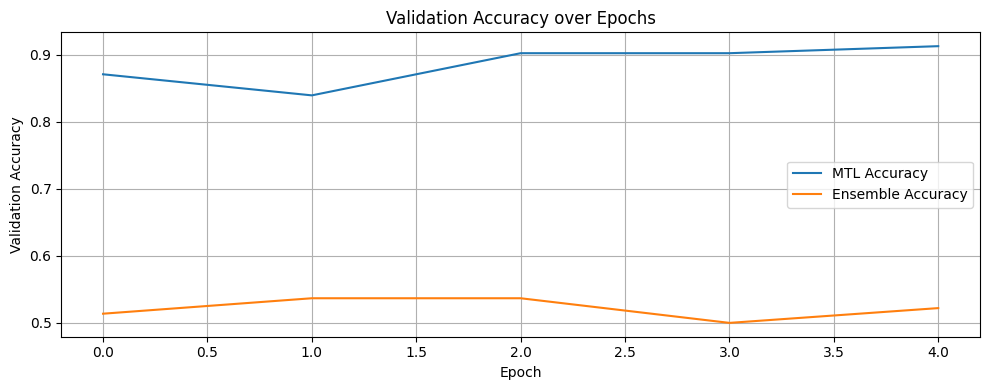

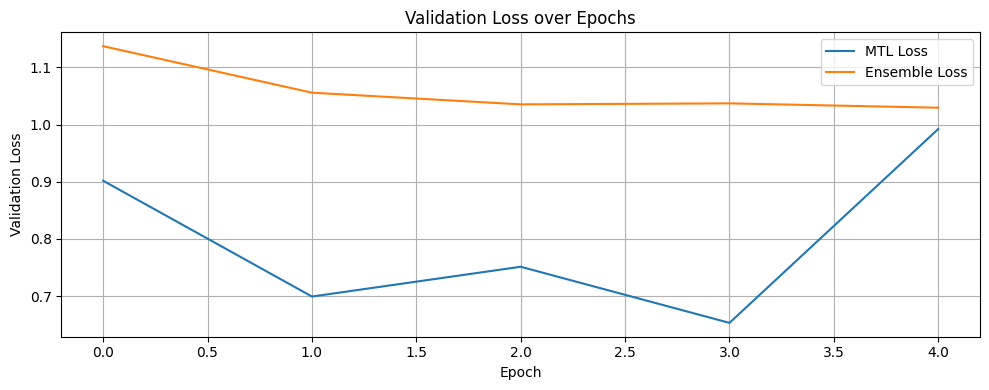

In [21]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(history['mtl_acc'], label='MTL Accuracy')
plt.plot(history['ensemble_acc'], label='Ensemble Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(history['mtl_loss'], label='MTL Loss')
plt.plot(history['ensemble_loss'], label='Ensemble Loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# generating plots with real prediction outputs

# STEP 1: Collect Predictions
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

def collect_predictions(model, dataloader, is_mtl=True):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            if is_mtl:
                out_h, out_f = outputs
                preds.append(torch.cat([out_h, out_f], dim=1).cpu())
                targets.append(labels.cpu())
            else:
                preds.append(outputs.cpu())
                targets.append(labels.cpu())

    return torch.cat(preds).numpy(), torch.cat(targets).numpy()

# STEP 2: Generate Predictions
# MTL Predictions
mtl_preds, mtl_targets = collect_predictions(mtl_model, val_loader, is_mtl=True)

# Ensemble Predictions
ens_preds_hernia, ens_targets_hernia = collect_predictions(ensemble_hernia_model, val_loader_hernia, is_mtl=False)
ens_preds_fibrosis, ens_targets_fibrosis = collect_predictions(ensemble_fibrosis_model, val_loader_fibrosis, is_mtl=False)

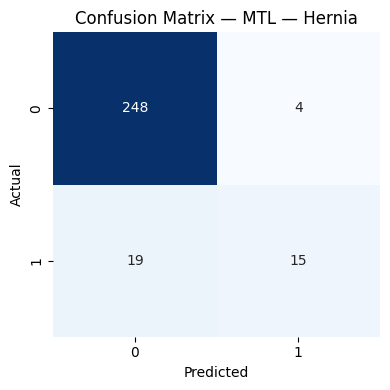

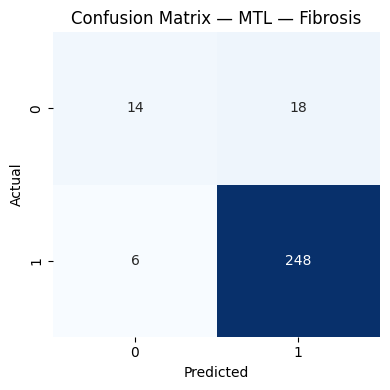

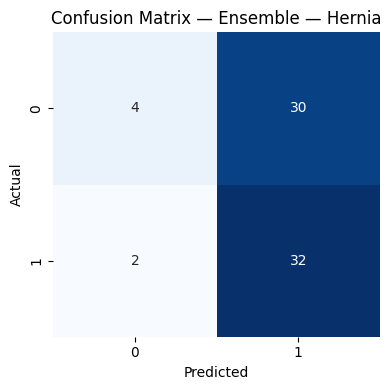

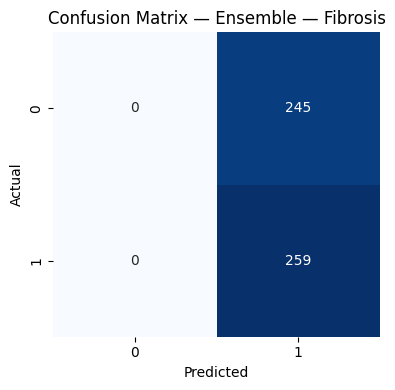

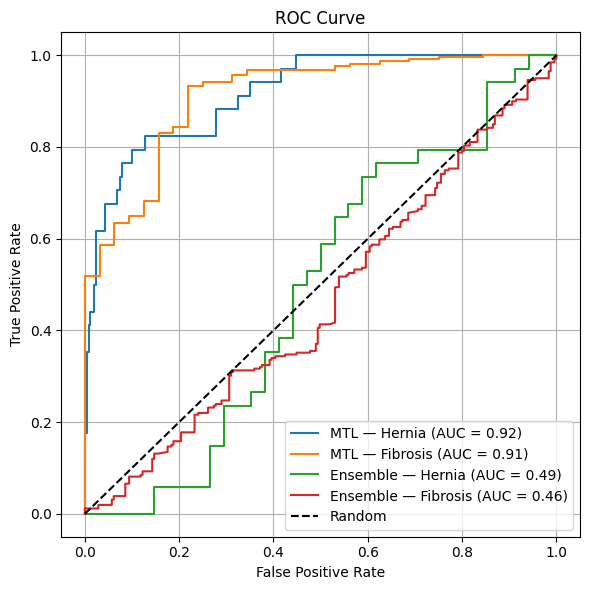

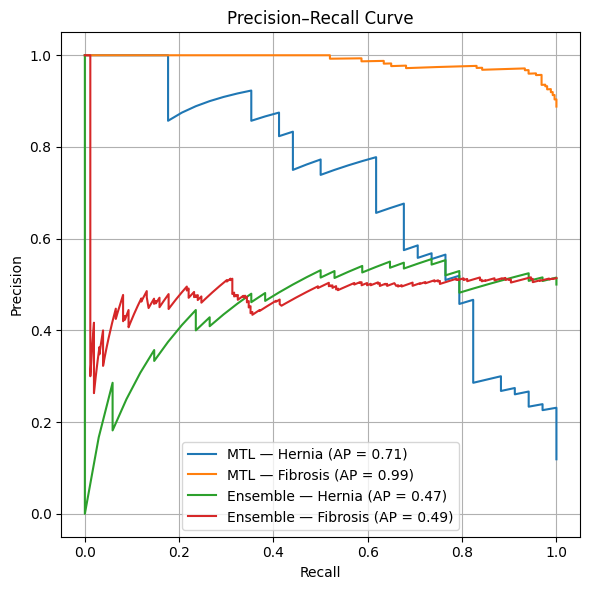

In [23]:
# 1. Confusion Matrices

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Apply 0.5 threshold for binary prediction
mtl_preds_bin = (mtl_preds > 0.5).astype(int)
ens_preds_hernia_bin = (ens_preds_hernia > 0.5).astype(int)
ens_preds_fibrosis_bin = (ens_preds_fibrosis > 0.5).astype(int)

# MTL
plot_conf_matrix(mtl_targets[:, 0], mtl_preds_bin[:, 0], "MTL — Hernia")
plot_conf_matrix(mtl_targets[:, 1], mtl_preds_bin[:, 1], "MTL — Fibrosis")

# Ensemble
plot_conf_matrix(ens_targets_hernia, ens_preds_hernia_bin, "Ensemble — Hernia")
plot_conf_matrix(ens_targets_fibrosis, ens_preds_fibrosis_bin, "Ensemble — Fibrosis")

# 2. ROC Curves
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.figure(figsize=(6, 6))
plot_roc_curve(mtl_targets[:, 0], mtl_preds[:, 0], "MTL — Hernia")
plot_roc_curve(mtl_targets[:, 1], mtl_preds[:, 1], "MTL — Fibrosis")
plot_roc_curve(ens_targets_hernia, ens_preds_hernia, "Ensemble — Hernia")
plot_roc_curve(ens_targets_fibrosis, ens_preds_fibrosis, "Ensemble — Fibrosis")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  3. Precision–Recall (PR) Curves

from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_score, label):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(recall, precision, label=f"{label} (AP = {ap:.2f})")

plt.figure(figsize=(6, 6))
plot_pr_curve(mtl_targets[:, 0], mtl_preds[:, 0], "MTL — Hernia")
plot_pr_curve(mtl_targets[:, 1], mtl_preds[:, 1], "MTL — Fibrosis")
plot_pr_curve(ens_targets_hernia, ens_preds_hernia, "Ensemble — Hernia")
plot_pr_curve(ens_targets_fibrosis, ens_preds_fibrosis, "Ensemble — Fibrosis")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Create filtered dataframes for test set
test_df_hernia = test_df[test_df['Primary Label'] == 'Hernia'].copy()
test_df_fibrosis = test_df[test_df['Primary Label'] == 'Fibrosis'].copy()

print("Hernia test label distribution:", test_df_hernia['Primary Label'].value_counts())
print("Fibrosis test label distribution:", test_df_fibrosis['Primary Label'].value_counts())

# Define true labels for test set
y_true_hernia = (test_df_hernia['Primary Label'] == 'Hernia').astype(int).values
y_true_fibrosis = (test_df_fibrosis['Primary Label'] == 'Fibrosis').astype(int).values

# inspecting label variability:
print("Unique labels in hernia test set:", np.unique(y_true_hernia))
print("Unique labels in fibrosis test set:", np.unique(y_true_fibrosis))

Hernia test label distribution: Primary Label
Hernia    34
Name: count, dtype: int64
Fibrosis test label distribution: Primary Label
Fibrosis    252
Name: count, dtype: int64
Unique labels in hernia test set: [1]
Unique labels in fibrosis test set: [1]
